# Sentiment Analysis of Movie Reviews pt.2 -- LSA

 I made a sentiment analysis of movie reviews from the dataset of reviews on imdb. In the last part, I first preprocessed the text of all reviews into lowercase stemmed stokens with numbers and punctuations stripped. Then, I used TF-IDF as word-embedding to vectorize the all words into sparse matrix. Afterwards, I ran several selected machine-learning models to classify the features, the sparse matrix, and evaluated their performances.

However, this was just the basics of sentiment analysis. Because we have a relatively small dataset (1000 entries), we do not need to consider the dimension of features. The dimension of features last time was 2317, as shown below:

In [5]:
X_train.get_shape()[1]

2317

However, what if we have a large dataset, like a million entries? The size of 1,000,000 x 2,317 is a super large for a  sparse matrix. It requires a strong computing power to store it and run it. It can also be exceedingly time-consuming. Therefore, we need to reduce the dimensionality of features and speed up our machine-learning process with a little loss of accuracy. In this part, I will conduct LSA on the Sentiment Analysis.
## LSA and SVD
Latent Semantic Analysis (LSA) is a common word-embedding method used in Topic Modelling. On the other hand, it is also useful for text classification. In short, LSA is to perform Singular Value Decomposition(SVD) on the matrix after TD-IDF vectorization. If you are not familiar with TF-IDF, please refer to the Pt.1 of this study. SVD is a powerful matrix decomposition method used in Natural Language Processing. In NLP, we can always encounter a huge amount of dimension for our features. We can use SVD to select a small amount of those dimensions to have a truncated matrix to process machine-learning. (Here is an informative [tutorial of SVD](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm))

To briefly explain SVD, we can decompose the matrix A as

$A = USV^T$

The original matrix $A$ is a $nxp$ matrix. $U$ is an $nxn$ matrix, containing n left singular vectors. $V$ is a $pxp$ matrix, containing p right singular vectors. $S$ is an $nxp$ diagonal matrix containing singular values on its diagonal. The rest elements off the diagonal are 0. The singular values $\sigma$ are lined up according to its value: $\sigma 1$ > $\sigma 2$ > ... > $\sigma k$

Among all those singular values, we can choose a small number of singular values we want. For example, I will choose first 100 among all 2317 singular values in this case, in order to significantly reduce the dimensionality. We will remain the first 100 left singular vectors in $U_k$, the first 100 singular values in the singular matrix $S_k$, and the first 100 right singular vectors in $V_k$, and multiply them to get the truncated matrix $A_k$ as:

$U_k S_k V_k^T = A_k$

In Python, we can use scikit-learn to get the truncated SVD, and normalize it to tranform the feature matrix. Here is the code:

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# performance SVD
svd = TruncatedSVD(100)
# performance LSA and normalization
lsa = make_pipeline(svd, MinMaxScaler())
X_lsa = lsa.fit_transform(X)

We can integrate this snippet of code into the preprocess method used in [part.1](https://charliezcr.github.io/sa_p1.html) and transform the dataset. Here is the 2.0 version of preprocess function:

In [40]:
from nltk.stem import PorterStemmer    # stem the words
from nltk.tokenize import word_tokenize # tokenize the sentences into tokens
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer # vectorize the texts
from sklearn.model_selection import train_test_split # split the testing and training sets
from sklearn.decomposition import TruncatedSVD # SVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

def preprocess(path):
    '''generate cleaned dataset
    
    Args:
        path(string): the path of the file of testing data

    Returns:
        X_train (list): the list of features of training data
        X_test (list): the list of features of test data
        y_train (list): the list of targets of training data ('1' or '0')
        y_test (list): the list of targets of training data ('1' or '0')
    '''
    
    # text preprocessing: iterate through the original file and 
    with open(path, encoding='utf-8') as file:
        # record all words and its label
        labels = []
        preprocessed = []
        for line in file:
            # get sentence and label
            sentence, label = line.strip('\n').split('\t')
            labels.append(int(label))
            
            # remove punctuation and numbers
            for ch in punctuation+'0123456789':
                sentence = sentence.replace(ch,' ')
            # tokenize the words and stem them
            words = []
            for w in word_tokenize(sentence):
                words.append(PorterStemmer().stem(w))
            preprocessed.append(' '.join(words))
    
    # vectorize the texts by tfidf
    vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True)
    X_tfidf = vectorizer.fit_transform(preprocessed)
    svd = TruncatedSVD(100)
    # perform lsa
    lsa = make_pipeline(svd, MinMaxScaler())
    X_lsa = lsa.fit_transform(X_tfidf)
    # split the testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X_lsa, labels, test_size=0.2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess('imdb_labelled.txt')

## Performance
We can apply the data transfromed by LSA to the machine-learning models and monitor the change in their performance. Remember that in part.1, the result for Linear Discriminant Analysis was:
>Time cost of LinearDiscriminantAnalysis(): 0.79s<br>
The accuracy of LinearDiscriminantAnalysis(): 0.71

Now, we have our data's dimensionality significantly reduced. We should expect the time cost to be drastically improved this time. Also, we do not even need to make the data dense this time!

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classify(LinearDiscriminantAnalysis())

Time cost of LinearDiscriminantAnalysis(): 0.05s
The accuracy of LinearDiscriminantAnalysis(): 0.73



We just reduced the time cost from 0.79s to 0.05s. This is a giant leap as for speed!

Remember that last time, we also tried Logistic Regression, MultinomialNB, SVC, SGD and MLP Classifiers. The performance was:
>Time cost of LogisticRegression(): 0.03s<br>
The accuracy of LogisticRegression(): 0.825<br>
<br>
Time cost of MultinomialNB(): 0.0s<br>
The accuracy of MultinomialNB(): 0.825<br>
<br>
Time cost of SVC(): 0.09s<br>
The accuracy of SVC(): 0.835<br>
<br>
Time cost of SGDClassifier(): 0.0s<br>
The accuracy of SGDClassifier(): 0.82<br>
<br>
Time cost of MLPClassifier(): 3.47s<br>
The accuracy of MLPClassifier(): 0.81<br>

We can try all those models and observe their performance:

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
for model in [LogisticRegression(), MultinomialNB(), SVC(), SGDClassifier(), MLPClassifier()]:
    classify(model)

Time cost of LogisticRegression(): 0.08s
The accuracy of LogisticRegression(): 0.76

Time cost of MultinomialNB(): 0.0s
The accuracy of MultinomialNB(): 0.775

Time cost of SVC(): 0.08s
The accuracy of SVC(): 0.745

Time cost of SGDClassifier(): 0.01s
The accuracy of SGDClassifier(): 0.75

Time cost of MLPClassifier(): 0.68s
The accuracy of MLPClassifier(): 0.77



We can see that even though the accuracy decreases a little for all those model, the speed is accelerated. The Time cost is significantly reduced for the complicated model MLP classifier. Therefore, MLP classifer and Linear Discriminant Classifier can be included in the ensemble classifier.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Time cost: 1.03s
Accuracy: 0.78



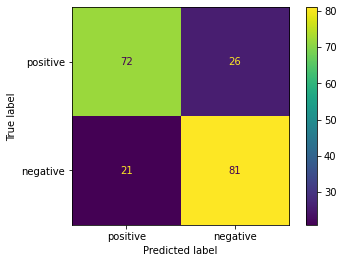

In [49]:
ensemble([LinearDiscriminantAnalysis(),LogisticRegression(),MultinomialNB(),SVC(),SGDClassifier(),MLPClassifier()])